In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import pickle as pkl
import os

import statsmodels.formula.api as smf
import seaborn as sns
import pandas as pd
import numpy as np

from auxiliary import *

np.random.seed(123)

###  Conditioning ot balance and conditioning to adjust

There exists only one back-door path $D \leftarrow S \leftrightarrow X \rightarrow Y$ and both $S$ nor $X$ are observable. Thus, we have a choice to condition on either one of them.

<img src="material/conditioning_balance_adjust.png" height=300 width=300 />

* $X$, regression estmiator, adjustment-for-other-causes conditioning strategy
* $S$, matching estimator, balancing conditioning strategy

**Agenda**

* matching as conditioning via stratification
* matching as weighting
* matching as data analysis algorithm

**Fundamental concepts**

* stratification of data
* weighting to achieve balance
* propensity scores

**Views on matching**

* method to form quasi-experimental constrasts by sampling comparable treatment and control cases
* as a nonparametric method of adjustment fro treatment assignment patterns

## Matching as conditioning via stratificaton

Individuals within groups determined by $S$ are entirely indistinguishable from each other in all ways except 

* observed treatment status

* differences in potential outcomes that are independent of treatment status

More formally,

\begin{align*}
E[Y^1 \mid D = 1, S] = E[Y^1 \mid D = 0, S] \\
E[Y^0 \mid D = 0, S] = E[Y^0 \mid D = 0, S]
\end{align*}

implied by ...

* treatment assignment is ignorable
* selection on observables

**ATC**

\begin{align*}
E[\delta \mid D = 0, S] & = E[Y^1 - Y^0 \mid D = 0, S] \\
                        & = E[Y^1 \mid D = 0, S] - E[Y^0 \mid D = 0, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 0, S] \\
                        & = E[Y \mid D = 1, S] - E[Y \mid D = 0, S] \\
\end{align*}

**ATT**
\begin{align*}
E[\delta \mid D = 1, S] & = E[Y^1 - Y^0 \mid D = 1, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 1, S] \\
                        & = E[Y^1 \mid D = 1, S] - E[Y^0 \mid D = 0, S] \\
                        & = E[Y \mid D = 1, S] - E[Y \mid D = 0, S] \\
\end{align*}

<img src="material/matching_demonstration_one.png" height=500 width=500 />

Let's study these idealized conditions for a simulated dataset.

In [6]:
def get_sample_matching_demonstration_1(num_agents):
    """Simulate sample
    
    Simulates a sample based for mathcing demonstration one using 
    the information provided in Table 6.1.
    
    Args:
        num_agents: An integer that specifies the number of individuals
            to sample.
            
    Returns:
        Returns a dataframe with the observables (Y, S, D) as well as
        the unobservables (Y_1, Y_0).
    """
    def get_potential_outcomes(s):
        """ Get potential outcomes.
        
        Assigns the potential outcomes based on the observable S and
        the information in Table 6.1.
        
        Notes:
            The two potential outcomes are solely a function of the 
            observable and are not associated with the treatment
            variable D.
        
        Args:
            s: an integer for the value of the stratification variable
            
        Returns:
            A tuple with the two potential outcomes.            
        """
        if s == 1:
            y_1, y_0 = 4, 2
        elif s == 2:
            y_1, y_0 = 8, 6
        elif s == 3:
            y_1, y_0 = 14, 10
        else:
            raise AssertionError
            
        # We want some randomness. 
        y_1 += np.random.normal()
        y_0 += np.random.normal()
                
        return y_1, y_0

    # Store some information about the sample variables
    # and initialize an empty dataframe.
    info = OrderedDict()
    info['Y'] = np.float
    info['D'] = np.int
    info['S'] = np.int
    info['Y_1'] = np.float
    info['Y_0'] = np.float
        
    df = pd.DataFrame(columns=info.keys())
    
    for i in range(num_agents):        
        # Simulate from the joint distribution of the 
        # observables.
        u = np.random.uniform()
        if 0.00 <= u < 0.36:
            s, d = 1, 0
        elif 0.36 <= u < 0.48:
            s, d = 2, 0
        elif 0.48 <= u < 0.60:
            s, d = 3, 0
        elif 0.60 <= u < 0.68:
            s, d = 1, 1
        elif 0.68 <= u < 0.80:
            s, d = 2, 1
        else:
            s, d = 3, 1

        # Get potential outcomes and determine observed
        # outcome.
        y_1, y_0 = get_potential_outcomes(s)
        y = d * y_1 + (1 - d) * y_0  
        
        # Collect information 
        df.loc[i] = y, d, s, y_1, y_0
    
    # We want to enforce suitable types for each column.
    # Unfortunately, this cannot be done at the time of
    # initialization.
    df = df.astype(info)
    
    return df

In [7]:
df = get_sample_matching_demonstration_1(num_agents=10000)
df[['Y', 'D', 'S']].head()

,Y,D,S
0,11.651437,0,3
1,13.795799,1,3
2,5.133260,0,2
3,5.380809,0,2
4,7.556018,1,2


In [50]:
print('The true average treatment effect is {:5.3f}'.format((df['Y_1'] - df['Y_0']).mean()))

The true average treatment effect is 2.647


In [51]:
stat = df['Y'][df['D'] == 1].mean() - df['Y'][df['D'] == 0].mean()
print('The naive estimate is {:5.3f}'.format(stat))

The naive estimate is 5.847


What to do?

In [27]:
df.groupby(['S', 'D'])['Y'].mean()

S  D
1  0     2.005091
   1     3.983288
2  0     6.040619
   1     7.950835
3  0     9.961677
   1    13.998312
Name: Y, dtype: float64

Note that the observed outcomes within each stratum correspond to the averate potential outcome within the stratum. We can compute the average treatment effect by looking at the difference within each strata.

In [28]:
stat = (4 - 2) * 0.44 + (8 - 6) * 0.24 + (14 - 10) * 0.32
print('Exploiting perfect stratification, we estimate {:5.3f}'.format(stat))

Exploiting perfect stratification, we estimate 2.640


The ATT and ATC can be computed analogously just by applying the appropriate weights to the strata-specific effect of treatment.

More generally.

\begin{align*}
\{E_N [y_i \mid d_i = 1, s = s_i] - E_N [y_i \mid d_i = 0, s = s_i]\} \\
\xrightarrow{p} E[Y^1 - Y^0\mid S = s] = E[\delta \mid S = s].
\end{align*}
Weighted sums of these stratified estimates can then be taken such as for the unconditional ATE:
\begin{align*}
& \sum_s \{E_N[y_i \mid d_i = 1, s_i = s] - E_N[y_i \mid d_i = 0, s_i = s]\} \\
& * {\Pr}_N[s_i = s] \xrightarrow{p} E[\delta]
\end{align*}


This examples shows all of the basic principles in matching estimators that we will discuss in greated detail in this lecture. 

* Treatment and control subjects are matched together in the sense theat they are grouped together into strata.

* An average difference between the outcomes of the treatment and control subjects is estimated, based on a weighting of the strata by common distribution.

### Overlap conditions

In [29]:
df = get_sample_matching_demonstration_2(num_agents=1000)
df[['Y', 'D', 'S']].head()

,Y,D,S
0,5.642426,0,2
1,15.401564,1,3
2,9.729472,0,3
3,13.059914,1,3
4,2.075422,0,1


In [30]:
df.groupby(['S', 'D'])['Y'].mean() 

S  D
1  0     1.977619
2  0     5.750006
   1     8.120596
3  0     9.952842
   1    14.105079
Name: Y, dtype: float64

What can we do?

## Matching as weighting


As indicated by the stylized example, there are often many strata where we do not have treated and control individuals available at the same time.

$\rightarrow$ combine information from different strata with the same propensity score $p$

**Definition** The estimated propensity score is the estimated probability of taking the treatment as a function of variables that predict treatment assignment, i.e. $\Pr[D = 1 \mid S]$.

$\rightarrow$ stratifying on the propensity score itself ameliorates the sparseness problem because the propensity score can be treated as a single stratifying variable.

In [31]:
a_grid = np.linspace(0.01, 1.00, 100)
b_grid = np.linspace(0.01, 1.00, 100)

df, counts = get_sample_matching_demonstration_3(a_grid, b_grid)
df.head()

,a,b,d,y,y_1,y_0,p
0,0.01,0.01,0,98.449017,98.401980,98.449017,0.330041
1,0.01,0.02,0,94.963182,101.956794,94.963182,0.331369
2,0.01,0.03,0,101.622931,101.434833,101.622931,0.332700
3,0.01,0.05,1,100.490135,100.490135,94.548580,0.335369
4,0.01,0.06,0,97.737132,93.222637,97.737132,0.336708


**underlying causal graphs**

<img src="material/fig-matching-demonstration-3.png" height=500 width=500 />

We will now look at different ways to construct estimates for the usual causal parameters. So, we first compute their true counterparts.

In [32]:
true_effects = list()
true_effects += [(df['y_1'] - df['y_0'])[(df['d'] == 1)].mean()]
true_effects += [(df['y_1'] - df['y_0'])[(df['d'] == 0)].mean()]
true_effects += [(df['y_1'] - df['y_0']).mean()]

In [33]:
print('The true estimate of the average causal effect is {:5.3f}'.format(true_effects[-1]))

stat = df['y'][df['d'] == 1].mean() - df['y'][df['d'] == 0].mean()
print('The naive estimate of the average causal effect is {:5.3f}'.format(stat))

The true estimate of the average causal effect is 4.506
The naive estimate of the average causal effect is 4.888


How about the issue of sparsity on the data?

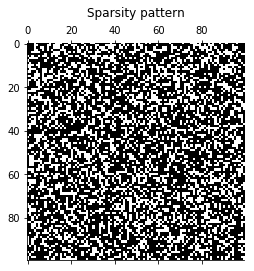

In [34]:
get_sparsity_pattern_overall(counts)

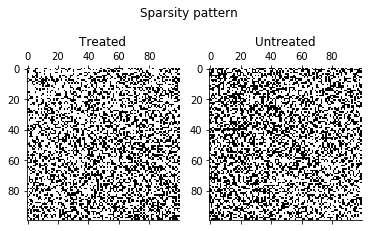

In [35]:
get_sparsity_pattern_by_treatment(counts)

How does the propensity score $P(D = 1\mid S)$ as a function of the observables $(a, b)$ look like?

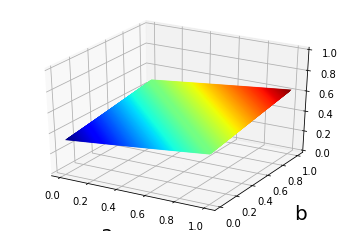

In [36]:
plot_propensity_score(a_grid, b_grid)

We still must be worried about common support.

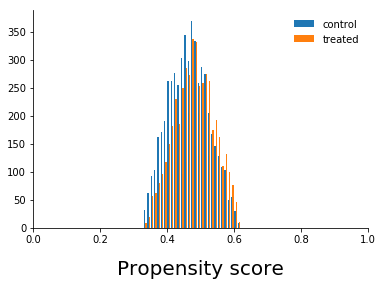

In [37]:
get_common_support(df)


\begin{align*}
\hat{\delta}_{\text{ATT, weight}} \equiv \left( \frac{1}{n^1}\sum_{i:d_i = 1} y_i\right) 
- \left(\frac{\sum_{i:d_i=0}\hat{r}_i y_i}{\sum_{i:d_i = 0} \hat{r}_i}\right)
\end{align*}

\begin{align*}
\hat{\delta}_{\text{ATC, weight}} \equiv 
\left(
\frac{\sum_{i: d_i = 1}\frac{y_i}{\hat{r}_i}}{\sum_{i: d_i = 1}\frac{1}{\hat{r}_i}}
\right)
- \left(\frac{1}{n^0} \sum_{i: d_i = 0} y_i\right) 
\end{align*}

\begin{align*}
\hat{\delta}_{\text{ATE, weight}} \equiv \left(\frac{1}{n}\sum_{i}d_i\right) \hat{\delta}_{\text{ATT, weight}} +  \left(1 - \frac{1}{n}\sum_{i}d_i\right) \hat{\delta}_{\text{ATC, weight}}
\end{align*}



**ATC weights** 

\begin{align*}
r_i = \frac{p_i}{1 - p_i}
\end{align*}

**ATT weights**

\begin{align*}
r_i = \frac{1 - p_i}{p_i}
\end{align*}


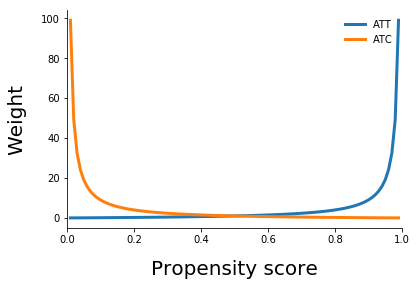

In [38]:
plot_weights()

In [39]:
def get_att_weight(df, p):
    """ Get weighted ATT.
    
    Calculates the weighted ATT basd on a provided
    dataset and the weights.
    
    Args:
        df: A dataframe with the observed data.
        p: A numpy array with the weights.
        
    Returns:
        A float which corresponds to the ATT.
    """
    weights = get_odds(p)
    
    is_control = (df['d'] == 0)
    is_treated = (df['d'] == 1)

    value, weights = df['y'][is_control], weights[is_control]
    att = df['y'][is_treated].mean() - np.average(value, weights=weights)
    
    return att
    
def get_atc_weight(df, p):
    """ Get weighted ATC.
    
    Calculates the weighted ATC basd on a provided
    dataset and the weights.
    
    Args:
        df: A dataframe with the observed data.
        p: A numpy array with the weights.
        
    Returns:
        A float which corresponds to the ATC.
    """
    weights = get_inv_odds(p)

    is_control = (df['d'] == 0)
    is_treated = (df['d'] == 1)

    value, weights = df['y'][is_treated], weights[is_treated]
    atc = np.average(value, weights=weights) - df['y'][is_control].mean()
    
    return atc

def get_ate_weight(df, p):
    """ Get weighted ATE.
    
    Calculates the weighted ATE basd on a provided
    dataset and the weights.
    
    Args:
        df: A dataframe with the observed data.
        p: A numpy array with the weights.
        
    Returns:
        A float which corresponds to the ATE.
    """
    share_treated = df['d'].value_counts(normalize=True)[1]

    atc = get_atc_weight(df, p)
    att = get_att_weight(df, p)

    return share_treated * att + (1.0 - share_treated) * atc

rslt = dict()
for model in ['true', 'correct', 'misspecified']:
    p = get_propensity_score_3(df, model)

    rslt[model] = list()
    rslt[model] += [get_att_weight(df, p)]
    rslt[model] += [get_atc_weight(df, p)]
    rslt[model] += [get_ate_weight(df, p)]
    
    print('')
    print(model.capitalize())
    print('estimated: ATT {:5.3f} ATC {:5.3f} ATE {:5.3f}'.format(*rslt[model]))
    print('true:      ATT {:5.3f} ATC {:5.3f} ATE {:5.3f}'.format(*true_effects))


True
estimated: ATT 4.644 ATC 4.419 ATE 4.525
true:      ATT 4.740 ATC 4.299 ATE 4.506
Optimization terminated successfully.
         Current function value: 0.682239
         Iterations 4

Correct
estimated: ATT 4.619 ATC 4.353 ATE 4.478
true:      ATT 4.740 ATC 4.299 ATE 4.506
Optimization terminated successfully.
         Current function value: 0.682467
         Iterations 4

Misspecified
estimated: ATT 4.620 ATC 4.371 ATE 4.488
true:      ATT 4.740 ATC 4.299 ATE 4.506


The covariates are balanced before any reweighting thanks to the assignment mechanisms.